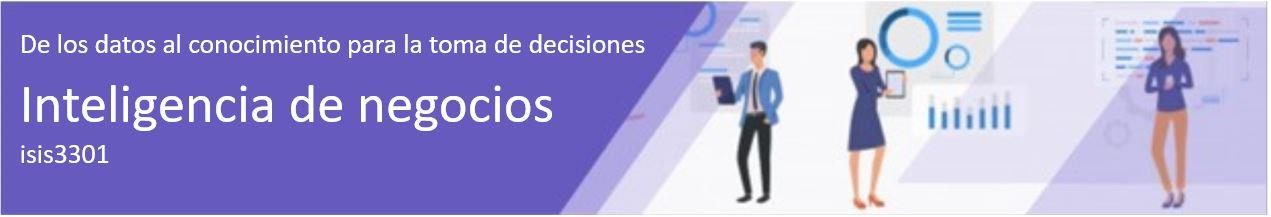

# Laboratorio 2 - Tarea de agrupación

- ### Estudiante 1: 
- ### Estudiante 2: 
- ### Estudiante 3: 


En este notebook se desarrolla un proyecto de analítica de datos para SenecaféAlpes. A partir de un conjunto de datos con atributos morfológicos de granos de café, se implementará la metodología CRISP-ML para construir y evaluar modelos de agrupación. El objetivo principal es identificar patrones naturales entre siete variedades registradas de café, aplicando algoritmos como K-Means y otras alternativas de clustering. Los resultados se validarán tanto de forma cuantitativa, como cualitativa, a través de la interpretación de los grupos encontrados en relación con los objetivos estratégicos de la organización.


Este notebook se encuentra dividido en las siguientes secciones:

ACTUALIZAR

# 1. Preparación de datos
## 1.0 Carga de librerías

In [225]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as osp
import joblib

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## 1.2 Cargar los datos

In [226]:
# Se cargan los datos. 
df = pd.read_csv('Datos_SenecaféAlpes.csv', sep=';', encoding = "ISO-8859-1")

## 1.3 Perfilamiento de datos

In [227]:
df.shape

(14291, 19)

In [228]:
df.head()

,ï»¿ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MÃ©todoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [229]:
df = df.rename(columns={'MÃ©todoSecado': 'MetodoSecado'})

In [230]:
# Revisar las características de los datos: completitud y tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ï»¿ID                14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

In [231]:
df = df.drop_duplicates()

In [232]:
# Resumen de los estadisticos de las variables numéricas
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,13830.000000,1.263300e+04,13442.000000,13830.000000,13248.000000,12449.000000,11978.000000,13830.000000,11612.000000,11823.000000,13197.000000,12743.000000,12763.000000,13370.000000,12707.000000
mean,52987.376283,7.718237e+05,319.766440,202.085824,0.749921,53521.754117,252.859008,0.749693,0.986761,0.873054,0.799310,0.006561,0.001713,0.643265,0.994272
std,29289.506819,3.267745e+05,86.155610,45.380543,0.099587,29472.383075,60.409029,0.050768,0.026347,0.063421,0.067767,0.001164,0.000601,0.100767,0.039720
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36340.750000,6.767770e+05,253.299100,175.835899,0.715508,36721.000000,215.298027,0.718653,0.985596,0.832776,0.762160,0.005903,0.001153,0.581195,0.993680
50%,44642.000000,7.718790e+05,296.485040,192.409413,0.764180,45091.000000,238.544800,0.759942,0.988280,0.883433,0.801157,0.006647,0.001693,0.641928,0.996380
75%,61259.250000,9.543480e+05,376.459017,216.804297,0.810428,62087.000000,279.453871,0.786893,0.989989,0.916817,0.834367,0.007274,0.002169,0.696228,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


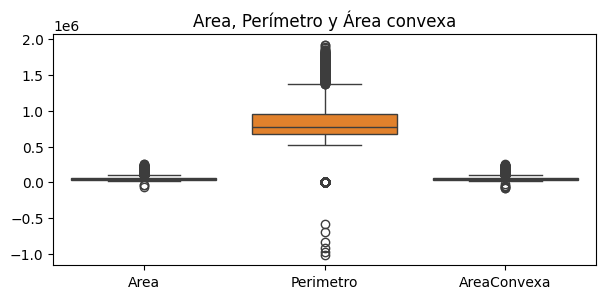

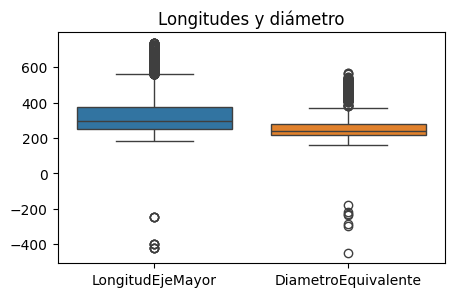

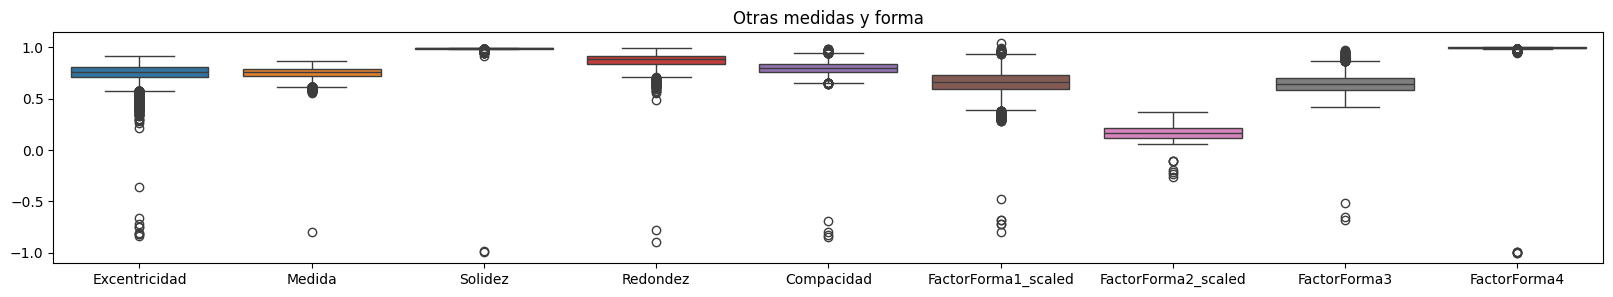

In [233]:
# Visualización de todas las variables numéricas

# graficamos por variables con dimensiones similares
# Area, Perímetro, Área convexa
fig=plt.figure(figsize=(7,3))
ax = sns.boxplot(data=df[["Area", "Perimetro", "AreaConvexa"]], orient="v")
plt.title("Area, Perímetro y Área convexa")
plt.show()

# LongitudEjes, Diámetros
fig=plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data=df[["LongitudEjeMayor", "LongitudEjeMayor", "DiametroEquivalente"]], orient="v")
plt.title("Longitudes y diámetro")
plt.show()

# otras medidas y forma
df["FactorForma1_scaled"] = df["FactorForma1"]*100
df["FactorForma2_scaled"] = df["FactorForma2"]*100
fig=plt.figure(figsize=(20,3))
ax3 = sns.boxplot(data=df[["Excentricidad", "Medida", "Solidez", "Redondez", "Compacidad", "FactorForma1_scaled", "FactorForma2_scaled", "FactorForma3", "FactorForma4"]], orient="v")
plt.title("Otras medidas y forma")
plt.show()

Evidentemente hay datos anoamlos, la excentricidad siempre es 0 o mayor a 0, medida también debe ser positivo, solidez también, redondez igual, compacidad, longitud, diametro, area y permitro igual.

In [234]:
(df["Excentricidad"] < 0).sum()

np.int64(9)

In [235]:
(df["Medida"] < 0).sum()

np.int64(1)

In [236]:
(df["Solidez"] < 0).sum()

np.int64(2)

In [237]:
(df["Redondez"] < 0).sum()

np.int64(2)

In [238]:
(df["Compacidad"] < 0).sum()

np.int64(4)

In [239]:
(df["LongitudEjeMayor"] < 0).sum()

np.int64(3)

In [240]:
(df["DiametroEquivalente"] < 0).sum()

np.int64(7)

In [241]:
(df["Area"] < 0).sum()

np.int64(3)

In [242]:
(df["AreaConvexa"] < 0).sum()

np.int64(6)

In [243]:
(df["Perimetro"] < 0).sum()

np.int64(6)

Como hay pocos datos anomalos, simplemente los podemos quitar.

In [244]:
df = df[df["Excentricidad"] >= 0]
df = df[df["Medida"] >= 0]
df = df[df["Solidez"] >= 0]
df = df[df["Redondez"] >= 0]
df = df[df["Compacidad"] >= 0]
df = df[df["LongitudEjeMayor"] >= 0]
df = df[df["DiametroEquivalente"] >= 0]
df = df[df["Area"] >= 0]
df = df[df["AreaConvexa"] >= 0]
df = df[df["Perimetro"] >= 0]

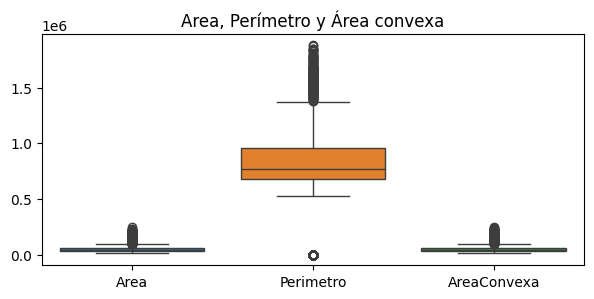

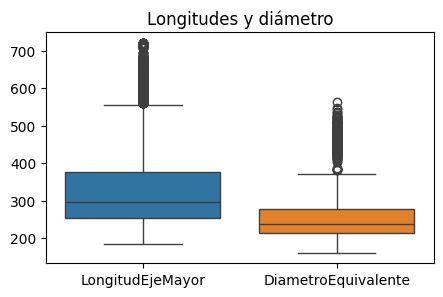

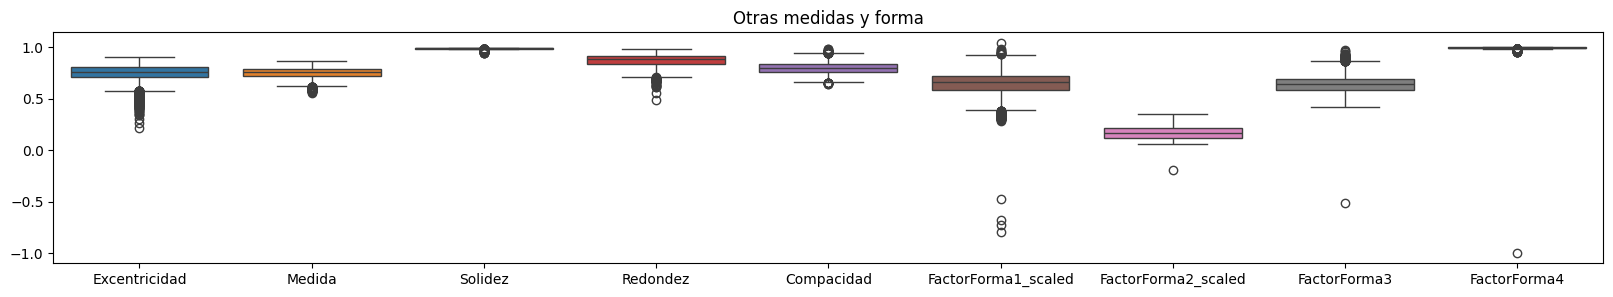

In [245]:
# Visualización de todas las variables numéricas

# graficamos por variables con dimensiones similares
# Area, Perímetro, Área convexa
fig=plt.figure(figsize=(7,3))
ax = sns.boxplot(data=df[["Area", "Perimetro", "AreaConvexa"]], orient="v")
plt.title("Area, Perímetro y Área convexa")
plt.show()

# LongitudEjes, Diámetros
fig=plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data=df[["LongitudEjeMayor", "LongitudEjeMayor", "DiametroEquivalente"]], orient="v")
plt.title("Longitudes y diámetro")
plt.show()

# otras medidas y forma
df["FactorForma1_scaled"] = df["FactorForma1"]*100
df["FactorForma2_scaled"] = df["FactorForma2"]*100
fig=plt.figure(figsize=(20,3))
ax3 = sns.boxplot(data=df[["Excentricidad", "Medida", "Solidez", "Redondez", "Compacidad", "FactorForma1_scaled", "FactorForma2_scaled", "FactorForma3", "FactorForma4"]], orient="v")
plt.title("Otras medidas y forma")
plt.show()

Más aún, el FactorForma1,2,3 y 4, con la infromación del diccionario es imposible saber si debería ser mayor a 0. Sin embargo, sabiendo que son medidas gemoetricas derivadas de las otras medidas, es posible que también deban ser positivas, entonces exploramos esta posibilidad.

In [246]:
(df["FactorForma1_scaled"] < 0).sum()

np.int64(4)

In [247]:
(df["FactorForma2_scaled"] < 0).sum()

np.int64(1)

In [248]:
(df["FactorForma3"] < 0).sum()

np.int64(1)

In [249]:
(df["FactorForma4"] < 0).sum()

np.int64(1)

In [250]:
df = df[df["FactorForma1_scaled"] >= 0]
df = df[df["FactorForma2_scaled"] >= 0]
df = df[df["FactorForma3"] >= 0]
df = df[df["FactorForma4"] >= 0]

In [251]:
df.isnull().sum()

ï»¿ID                    0
Area                     0
Perimetro                0
LongitudEjeMayor         0
LongitudEjeMenor         0
RelacionAspecto        148
Excentricidad            0
AreaConvexa              0
DiametroEquivalente      0
Medida                   0
Solidez                  0
Redondez                 0
Compacidad               0
FactorForma1             0
FactorForma2             0
FactorForma3             0
FactorForma4             0
DefectoVisible         964
MetodoSecado           189
FactorForma1_scaled      0
FactorForma2_scaled      0
dtype: int64

De los datos vemos que hay 3 columnas problematicas: RelacionAspecto, DefectoVisible y MetodoSecado. Como defectoVisibles tiene tantos valores vacíos es mejor simplemente dehacernos de toda la columna. Para las otras dos podemos hacer una inputacion de datos con la media de la columna.También quitamos el id, que no aporta información para la clasificación.

In [252]:
df = df.drop(columns=["DefectoVisible","ï»¿ID"])

In [253]:
df = df.fillna(df.mean(numeric_only=True))

## Col cateogricas

In [254]:
df

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MetodoSecado,FactorForma1_scaled,FactorForma2_scaled
2,59965,994266.00,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Natural,0.648859,0.101801
4,39324,737773.00,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Lavado,0.667583,0.217355
10,39948,731068.00,244.969135,207.964148,Redondeado,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,0.920643,0.006132,0.002717,0.847583,0.998402,Lavado,0.613220,0.271745
11,39392,746.64,265.915971,189.144664,Alargado,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,0.842199,0.006751,0.002095,0.709299,0.997194,Natural,0.675051,0.209496
18,46757,829953.00,307.901337,194.605988,Alargado,0.774936,47292.0,243.993568,0.720169,0.988687,0.853001,0.792441,0.006585,0.001602,0.627962,0.993548,Natural,0.658514,0.160181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29882,649082.00,247.427847,154.779257,Alargado,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,0.788336,0.008280,0.001973,0.621474,0.993478,Natural,0.828016,0.197271
14285,32384,657952.00,238.548336,173.086148,Alargado,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,0.851224,0.007366,0.002386,0.724582,0.998624,Lavado,0.736624,0.238562
14286,83266,1117778.00,448.473710,237.747098,Alargado,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,0.726026,0.005386,0.000923,0.527113,0.994319,Lavado,0.538604,0.092312
14287,39857,755392.00,283.623668,179.430885,Alargado,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,0.794264,0.007116,0.001747,0.630855,0.997183,Natural,0.711603,0.174694


In [255]:
df["MetodoSecado"].unique()

array(['Natural', 'Lavado', 'lavado', nan, 'natural', 'Honey', 'honey'],
      dtype=object)

In [256]:
df["RelacionAspecto"].unique()

array(['Alargado', 'Redondeado', 'alargado', nan, 'redondeado'],
      dtype=object)

Hay un error donde la misma cateogría está dividida en 2 por el uso de mayusculas.

In [257]:
df["MetodoSecado"] = df["MetodoSecado"].str.lower()
df["RelacionAspecto"] = df["RelacionAspecto"].str.lower()

In [258]:
imputer = SimpleImputer(strategy="most_frequent")
df[["MetodoSecado"]] = imputer.fit_transform(df[["MetodoSecado"]])
df[["RelacionAspecto"]] = imputer.fit_transform(df[["RelacionAspecto"]])

In [259]:
df["MetodoSecado"].unique()

array(['natural', 'lavado', 'honey'], dtype=object)

In [260]:
df["RelacionAspecto"].unique()

array(['alargado', 'redondeado'], dtype=object)

In [261]:
df = pd.get_dummies(df, columns=['MetodoSecado','RelacionAspecto'])

In [262]:
df

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,...,FactorForma2,FactorForma3,FactorForma4,FactorForma1_scaled,FactorForma2_scaled,MetodoSecado_honey,MetodoSecado_lavado,MetodoSecado_natural,RelacionAspecto_alargado,RelacionAspecto_redondeado
2,59965,994266.00,389.088529,197.967275,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,...,0.001018,0.504326,0.991211,0.648859,0.101801,False,False,True,True,False
4,39324,737773.00,262.520242,191.176858,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,...,0.002174,0.726511,0.997630,0.667583,0.217355,False,True,False,True,False
10,39948,731068.00,244.969135,207.964148,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,...,0.002717,0.847583,0.998402,0.613220,0.271745,False,True,False,False,True
11,39392,746.64,265.915971,189.144664,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,...,0.002095,0.709299,0.997194,0.675051,0.209496,False,False,True,True,False
18,46757,829953.00,307.901337,194.605988,0.774936,47292.0,243.993568,0.720169,0.988687,0.853001,...,0.001602,0.627962,0.993548,0.658514,0.160181,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29882,649082.00,247.427847,154.779257,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,...,0.001973,0.621474,0.993478,0.828016,0.197271,False,False,True,True,False
14285,32384,657952.00,238.548336,173.086148,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,...,0.002386,0.724582,0.998624,0.736624,0.238562,False,True,False,True,False
14286,83266,1117778.00,448.473710,237.747098,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,...,0.000923,0.527113,0.994319,0.538604,0.092312,False,True,False,True,False
14287,39857,755392.00,283.623668,179.430885,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,...,0.001747,0.630855,0.997183,0.711603,0.174694,False,False,True,True,False
